In [120]:
!pip install datasketch

In [127]:
import pandas as pd
df = pd.read_csv("jaccard_benchmark.tsv", sep="\t")


df = df[df.bits.isin([4, 5, 6])]
df

,precision,bits,exact,hll,set1,set2
3,4,4,0.451163,0.521435,"55,758,458,408,311,618,850,199,436,677,253,814...","108,417,157,409,309,246,451,71,77,625,942,233,..."
4,4,5,0.451163,0.521435,"55,758,458,408,311,618,850,199,436,677,253,814...","108,417,157,409,309,246,451,71,77,625,942,233,..."
5,4,6,0.451163,0.521435,"55,758,458,408,311,618,850,199,436,677,253,814...","108,417,157,409,309,246,451,71,77,625,942,233,..."
9,5,4,0.451163,0.523263,"55,758,458,408,311,618,850,199,436,677,253,814...","108,417,157,409,309,246,451,71,77,625,942,233,..."
10,5,5,0.451163,0.523263,"55,758,458,408,311,618,850,199,436,677,253,814...","108,417,157,409,309,246,451,71,77,625,942,233,..."
...,...,...,...,...,...,...
8392,16,5,0.471412,0.468786,"952,712,604,362,582,573,840,299,221,387,484,25...","540,369,335,198,763,460,242,508,287,739,286,73..."
8393,16,6,0.471412,0.468786,"952,712,604,362,582,573,840,299,221,387,484,25...","540,369,335,198,763,460,242,508,287,739,286,73..."
8397,17,4,0.471412,0.469518,"952,712,604,362,582,573,840,299,221,387,484,25...","540,369,335,198,763,460,242,508,287,739,286,73..."
8398,17,5,0.471412,0.469518,"952,712,604,362,582,573,840,299,221,387,484,25...","540,369,335,198,763,460,242,508,287,739,286,73..."


In [128]:
from datasketch import MinHash
from tqdm.auto import tqdm

In [135]:
import math

bits = df.bits.unique()
precision = df.precision.unique()

number_of_words = [
    # We divide again by 2 because the number of permutations used is a u64
    # and by two again as 
    math.ceil(b * 2**p / 32) // 2 // 2
    for b in bits
    for p in precision
]

number_of_words = [
    word
    for word in number_of_words
    if word > 0
]

In [136]:
from typing import List

def get_perfs(row) -> List:
    row = row[1]
    new_results = []
    set1 = [
        l.encode("utf8")
        for l in row.set1.split(",")
    ]
    set2 = [
        r.encode("utf8")
        for r in row.set2.split(",")
    ]
    for number_of_permutations in number_of_words:
        left_min_hash = MinHash(
            num_perm=number_of_permutations
        )
        right_min_hash = MinHash(
            num_perm=number_of_permutations
        )
        for left in set1:
            left_min_hash.update(left)
        for right in set2:
            right_min_hash.update(right)
        estimated = left_min_hash.jaccard(right_min_hash)
        new_results.append({
            "exact": row.exact,
            "set1": row.set1,
            "set2": row.set2,
            "approximation": estimated,
            "number_of_permutations": number_of_permutations
        })
    return new_results

In [137]:
from multiprocessing import Pool

with Pool(24) as p:
    results = list(tqdm(
        p.imap(
            get_perfs,
            df.iterrows()
        ),
        total=df.shape[0]
    ))

  0%|          | 0/4200 [00:00<?, ?it/s]

In [138]:
as_df = pd.DataFrame([
    r
    for result in tqdm(results)
    for r in result
])

  0%|          | 0/4200 [00:00<?, ?it/s]

In [139]:
as_df

,exact,set1,set2,approximation,number_of_permutations
0,0.451163,"55,758,458,408,311,618,850,199,436,677,253,814...","108,417,157,409,309,246,451,71,77,625,942,233,...",0.000000,1
1,0.451163,"55,758,458,408,311,618,850,199,436,677,253,814...","108,417,157,409,309,246,451,71,77,625,942,233,...",0.500000,2
2,0.451163,"55,758,458,408,311,618,850,199,436,677,253,814...","108,417,157,409,309,246,451,71,77,625,942,233,...",0.500000,4
3,0.451163,"55,758,458,408,311,618,850,199,436,677,253,814...","108,417,157,409,309,246,451,71,77,625,942,233,...",0.750000,8
4,0.451163,"55,758,458,408,311,618,850,199,436,677,253,814...","108,417,157,409,309,246,451,71,77,625,942,233,...",0.625000,16
...,...,...,...,...,...
163795,0.471412,"952,712,604,362,582,573,840,299,221,387,484,25...","540,369,335,198,763,460,242,508,287,739,286,73...",0.463542,384
163796,0.471412,"952,712,604,362,582,573,840,299,221,387,484,25...","540,369,335,198,763,460,242,508,287,739,286,73...",0.464844,768
163797,0.471412,"952,712,604,362,582,573,840,299,221,387,484,25...","540,369,335,198,763,460,242,508,287,739,286,73...",0.470703,1536
163798,0.471412,"952,712,604,362,582,573,840,299,221,387,484,25...","540,369,335,198,763,460,242,508,287,739,286,73...",0.462891,3072


In [140]:
df.rename(columns={
    "hll": "approximation"
}, inplace=True)
df

,precision,bits,exact,approximation,set1,set2
3,4,4,0.451163,0.521435,"55,758,458,408,311,618,850,199,436,677,253,814...","108,417,157,409,309,246,451,71,77,625,942,233,..."
4,4,5,0.451163,0.521435,"55,758,458,408,311,618,850,199,436,677,253,814...","108,417,157,409,309,246,451,71,77,625,942,233,..."
5,4,6,0.451163,0.521435,"55,758,458,408,311,618,850,199,436,677,253,814...","108,417,157,409,309,246,451,71,77,625,942,233,..."
9,5,4,0.451163,0.523263,"55,758,458,408,311,618,850,199,436,677,253,814...","108,417,157,409,309,246,451,71,77,625,942,233,..."
10,5,5,0.451163,0.523263,"55,758,458,408,311,618,850,199,436,677,253,814...","108,417,157,409,309,246,451,71,77,625,942,233,..."
...,...,...,...,...,...,...
8392,16,5,0.471412,0.468786,"952,712,604,362,582,573,840,299,221,387,484,25...","540,369,335,198,763,460,242,508,287,739,286,73..."
8393,16,6,0.471412,0.468786,"952,712,604,362,582,573,840,299,221,387,484,25...","540,369,335,198,763,460,242,508,287,739,286,73..."
8397,17,4,0.471412,0.469518,"952,712,604,362,582,573,840,299,221,387,484,25...","540,369,335,198,763,460,242,508,287,739,286,73..."
8398,17,5,0.471412,0.469518,"952,712,604,362,582,573,840,299,221,387,484,25...","540,369,335,198,763,460,242,508,287,739,286,73..."


In [141]:
df["memory"] = 2**df.precision * df.bits
df["label"] = "HLL"

In [142]:
as_df["memory"] = as_df.number_of_permutations * 64
as_df["label"] = "MinHash"

In [143]:
as_df["squared_error"] = (as_df.exact - as_df.approximation)**2
data_minhash = as_df.groupby("memory")["squared_error"].agg(["mean", "std"]).reset_index()
data_minhash

,memory,mean,std
0,64,0.245700,0.038829
1,128,0.111834,0.119985
2,192,0.066232,0.082250
3,256,0.044520,0.058444
4,320,0.036147,0.044547
5,384,0.029469,0.043038
6,512,0.026213,0.042823
7,640,0.020692,0.030712
8,768,0.016957,0.021559
9,1024,0.014456,0.024051


In [144]:
df["squared_error"] = (df.exact - df.approximation)**2
data_hll = df.groupby(["precision", "bits", "memory"])["squared_error"].agg(["mean", "std"])
data_hll = data_hll.reset_index()
data_hll

,precision,bits,memory,mean,std
0,4,4,64,0.030784,0.032352
1,4,5,80,0.030784,0.032352
2,4,6,96,0.030784,0.032352
3,5,4,128,0.012194,0.016551
4,5,5,160,0.012194,0.016551
5,5,6,192,0.012194,0.016551
6,6,4,256,0.016154,0.016725
7,6,5,320,0.016154,0.016725
8,6,6,384,0.016154,0.016725
9,7,4,512,0.005174,0.007540


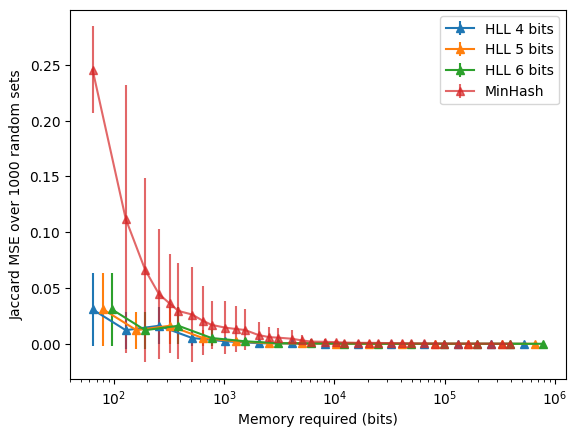

In [145]:
import matplotlib.pyplot as plt

for bits in data_hll["bits"].unique():
    filtered = data_hll[data_hll.bits == bits]
    plt.errorbar(
        filtered.memory,
        filtered["mean"],
        filtered["std"],
        marker='^',
        label=f"HLL {bits} bits"
    )
plt.errorbar(
    data_minhash.memory,
    data_minhash["mean"],
    data_minhash["std"],
    marker='^',
    label="MinHash",
    alpha=0.7
)
plt.legend()
plt.xscale("log")
#plt.yscale("log")
plt.ylabel("Jaccard MSE over 1000 random sets")
plt.xlabel("Memory required (bits)")
plt.show()

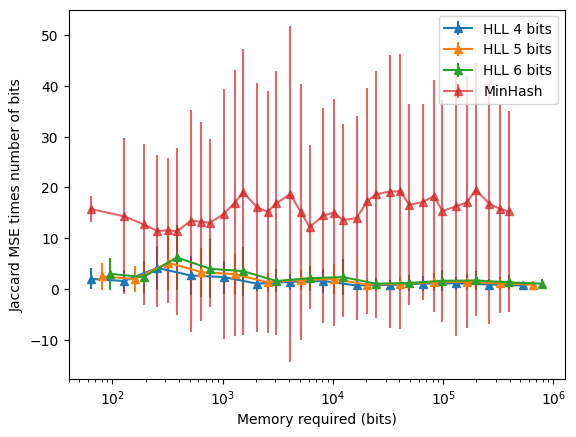

In [146]:
import matplotlib.pyplot as plt


for bits in data_hll["bits"].unique():
    filtered = data_hll[data_hll.bits == bits]
    plt.errorbar(
        filtered.memory,
        filtered["mean"] * filtered.memory,
        filtered["std"] * filtered.memory,
        marker='^',
        label=f"HLL {bits} bits"
    )

plt.errorbar(
    data_minhash.memory,
    data_minhash["mean"] * data_minhash.memory,
    data_minhash["std"] * data_minhash.memory,
    marker='^',
    label="MinHash",
    alpha=0.7
)
plt.legend()
plt.xscale("log")
plt.ylabel("Jaccard MSE times number of bits")
plt.xlabel("Memory required (bits)")
plt.show()